<a href="https://colab.research.google.com/github/cdiegor/MineracaoDeDados/blob/main/RecSys_ALS%2B2T.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sistemas de Recomendação — MovieLens (ALS + Two-Tower)

Este caderno treina dois modelos no **MovieLens 100k**:

- **ALS implícito (pedagógico)** — fatoração de matriz.
- **Two-Tower** — duas redes (usuário e item) com embeddings e produto interno.

Também inclui **métricas** (Recall@K, NDCG@K) e **ilustrações**:
- Mapas de calor para as matrizes de fatores **U** (usuários) e **P** (itens) do ALS.
- Diagrama simples das duas torres em paralelo.


## Requisitos

In [ ]:
# !pip install numpy scipy pandas matplotlib scikit-learn tensorflow

## 1) Imports e utilidades

In [ ]:
import os, io, zipfile, urllib.request, math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.model_selection import train_test_split
from scipy import sparse
import tensorflow as tf
from tensorflow.keras import layers, Model

print('NumPy:', np.__version__)
print('Pandas:', pd.__version__)
print('TensorFlow:', tf.__version__)

NumPy: 2.0.2
Pandas: 2.2.2
TensorFlow: 2.19.0


## 2) Baixar/Carregar MovieLens 100k (com fallback offline)

In [ ]:
DATA_DIR = Path('data_movielens'); DATA_DIR.mkdir(exist_ok=True)

def download_movielens_100k(target_dir: Path = DATA_DIR):
    url = 'https://files.grouplens.org/datasets/movielens/ml-100k.zip'
    zip_path = target_dir / 'ml-100k.zip'
    extracted_dir = target_dir / 'ml-100k'
    if extracted_dir.exists():
        return extracted_dir
    try:
        print('Baixando MovieLens 100k...')
        urllib.request.urlretrieve(url, zip_path)
        with zipfile.ZipFile(zip_path, 'r') as z:
            z.extractall(target_dir)
        print('OK:', extracted_dir)
        return extracted_dir
    except Exception as e:
        print('[AVISO] Falha no download:', e)
        return None

ml_dir = download_movielens_100k()

Baixando MovieLens 100k...
OK: data_movielens/ml-100k


In [ ]:
def load_movielens_100k(ml_dir: Path):
    data_path = ml_dir / 'ml-100k' / 'u.data' if (ml_dir and (ml_dir/'ml-100k').exists()) else (ml_dir/'u.data' if ml_dir else None)
    if data_path is None or not data_path.exists():
        raise FileNotFoundError('Arquivo u.data não encontrado.')
    cols = ['user','item','rating','ts']
    df = pd.read_csv(data_path, sep='\t', header=None, names=cols, engine='python')
    return df

try:
    ratings_df = load_movielens_100k(ml_dir if ml_dir else DATA_DIR)
except Exception as e:
    print('[AVISO] Usando dados sintéticos (substitua por MovieLens real quando possível):', e)
    rng = np.random.default_rng(42)
    users = np.arange(1, 501)
    items = np.arange(1, 2001)
    rows = []
    for u in users:
        liked = rng.choice(items, size=30, replace=False)
        for it in liked:
            rows.append((u, it, int(rng.integers(3,6)), int(rng.integers(9_000_000, 10_000_000))))
    ratings_df = pd.DataFrame(rows, columns=['user','item','rating','ts'])

ratings_df.head()

,user,item,rating,ts
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


## 3) Remapeamento de IDs e divisão (temporal, se disponível)

In [ ]:
def remap_ids(df):
    uid_map = {uid:i for i,uid in enumerate(sorted(df['user'].unique()))}
    iid_map = {iid:i for i,iid in enumerate(sorted(df['item'].unique()))}
    df2 = df.copy()
    df2['uid'] = df2['user'].map(uid_map)
    df2['iid'] = df2['item'].map(iid_map)
    return df2, uid_map, iid_map

ratings_df, uid_map, iid_map = remap_ids(ratings_df)
n_users = ratings_df['uid'].nunique()
n_items = ratings_df['iid'].nunique()
print('n_users, n_items:', n_users, n_items, 'interações:', len(ratings_df))

if 'ts' in ratings_df.columns and ratings_df['ts'].nunique() > 1:
    ratings_df = ratings_df.sort_values('ts')
    cut = int(0.8*len(ratings_df))
    train_df = ratings_df.iloc[:cut]
    test_df  = ratings_df.iloc[cut:]
else:
    train_df, test_df = train_test_split(ratings_df, test_size=0.2, random_state=42)

train_df.shape, test_df.shape

n_users, n_items: 943 1682 interações: 100000


((80000, 6), (20000, 6))

## 4) Matrizes esparsas (feedback implícito)

In [ ]:
train_p = sparse.coo_matrix((np.ones(len(train_df)), (train_df['uid'], train_df['iid'])), shape=(n_users, n_items)).tocsr()
test_p  = sparse.coo_matrix((np.ones(len(test_df )), (test_df['uid'],  test_df['iid'] )), shape=(n_users, n_items)).tocsr()
train_p, test_p

(<Compressed Sparse Row sparse matrix of dtype 'float64'
 	with 80000 stored elements and shape (943, 1682)>,
 <Compressed Sparse Row sparse matrix of dtype 'float64'
 	with 20000 stored elements and shape (943, 1682)>)

## 5) ALS Implícito (didático)

In [ ]:
def als_implicit(train_p, factors=32, reg=0.1, alpha=40.0, iters=6, seed=42):
    rng = np.random.default_rng(seed)
    m, n = train_p.shape
    X = 0.01 * rng.standard_normal((m, factors))
    Y = 0.01 * rng.standard_normal((n, factors))
    I = np.eye(factors)
    csr = train_p.tocsr(); csc = train_p.tocsc()
    for it in range(iters):
        YtY = Y.T @ Y + reg * I
        for u in range(m):
            start,end = csr.indptr[u], csr.indptr[u+1]
            idx = csr.indices[start:end]
            if len(idx)==0:
                X[u] = np.linalg.solve(YtY, np.zeros(factors))
                continue
            Cu = alpha * np.ones(len(idx))
            Y_u = Y[idx]
            A = YtY + (Y_u.T * Cu) @ Y_u
            b = (1 + Cu) @ Y_u
            X[u] = np.linalg.solve(A, b)
        XtX = X.T @ X + reg * I
        for i in range(n):
            start,end = csc.indptr[i], csc.indptr[i+1]
            idx = csc.indices[start:end]
            if len(idx)==0:
                Y[i] = np.linalg.solve(XtX, np.zeros(factors))
                continue
            Ci = alpha * np.ones(len(idx))
            X_i = X[idx]
            A = XtX + (X_i.T * Ci) @ X_i
            b = (1 + Ci) @ X_i
            Y[i] = np.linalg.solve(A, b)
        print(f"[ALS] it {it+1}/{iters}")
    return X, Y

X_als, Y_als = als_implicit(train_p, factors=32, reg=0.1, alpha=40.0, iters=50, seed=42)
X_als.shape, Y_als.shape

[ALS] it 1/50
[ALS] it 2/50
[ALS] it 3/50
[ALS] it 4/50
[ALS] it 5/50
[ALS] it 6/50
[ALS] it 7/50
[ALS] it 8/50
[ALS] it 9/50
[ALS] it 10/50
[ALS] it 11/50
[ALS] it 12/50
[ALS] it 13/50
[ALS] it 14/50
[ALS] it 15/50
[ALS] it 16/50
[ALS] it 17/50
[ALS] it 18/50
[ALS] it 19/50
[ALS] it 20/50
[ALS] it 21/50
[ALS] it 22/50
[ALS] it 23/50
[ALS] it 24/50
[ALS] it 25/50
[ALS] it 26/50
[ALS] it 27/50
[ALS] it 28/50
[ALS] it 29/50
[ALS] it 30/50
[ALS] it 31/50
[ALS] it 32/50
[ALS] it 33/50
[ALS] it 34/50
[ALS] it 35/50
[ALS] it 36/50
[ALS] it 37/50
[ALS] it 38/50
[ALS] it 39/50
[ALS] it 40/50
[ALS] it 41/50
[ALS] it 42/50
[ALS] it 43/50
[ALS] it 44/50
[ALS] it 45/50
[ALS] it 46/50
[ALS] it 47/50
[ALS] it 48/50
[ALS] it 49/50
[ALS] it 50/50


((943, 32), (1682, 32))

### Métricas @K e avaliação do ALS

In [ ]:
def recall_at_k(recommended, ground_truth, k=10):
    hits = len(set(recommended[:k]) & set(ground_truth))
    return hits / min(k, len(ground_truth)) if ground_truth else 0.0

def ndcg_at_k(recommended, ground_truth, k=10):
    gt = set(ground_truth)
    dcg = 0.0
    for rank, iid in enumerate(recommended[:k], start=1):
        if iid in gt:
            dcg += 1.0 / math.log2(rank + 1)
    ideal = min(len(ground_truth), k)
    idcg = sum(1.0 / math.log2(r+1) for r in range(1, ideal+1))
    return dcg / idcg if idcg > 0 else 0.0

def recommend_als_for_user(u, X, Y, train_p, topk=10):
    scores = X[u] @ Y.T
    seen = set(train_p[u].indices.tolist())
    ranking = np.argsort(-scores)
    ranking = [i for i in ranking if i not in seen]
    return ranking[:topk]

def eval_model(X, Y, train_p, test_p, k=20):
    recs, ndcgs = [], []
    for u in range(test_p.shape[0]):
        gt = test_p[u].indices.tolist()
        if not gt:
            continue
        reco = recommend_als_for_user(u, X, Y, train_p, topk=max(100, k))
        recs.append(recall_at_k(reco, gt, k))
        ndcgs.append(ndcg_at_k(reco, gt, k))
    return float(np.mean(recs) if recs else 0.0), float(np.mean(ndcgs) if ndcgs else 0.0)

recall10_als, ndcg10_als = eval_model(X_als, Y_als, train_p, test_p, k=20)
print(f"ALS — Recall@10: {recall10_als:.4f} | NDCG@10: {ndcg10_als:.4f}")

ALS — Recall@10: 0.0710 | NDCG@10: 0.0576


### Ilustrações das matrizes de fatores U e P (ALS)

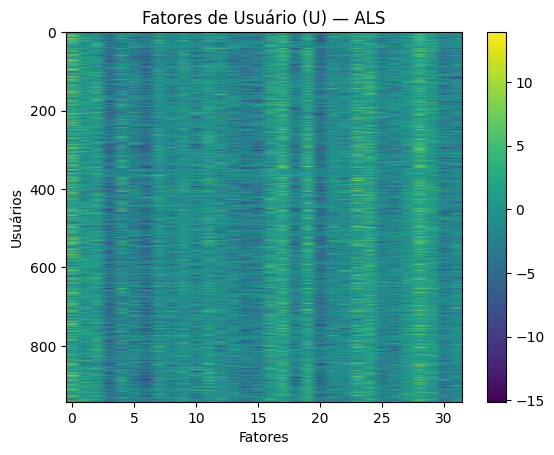

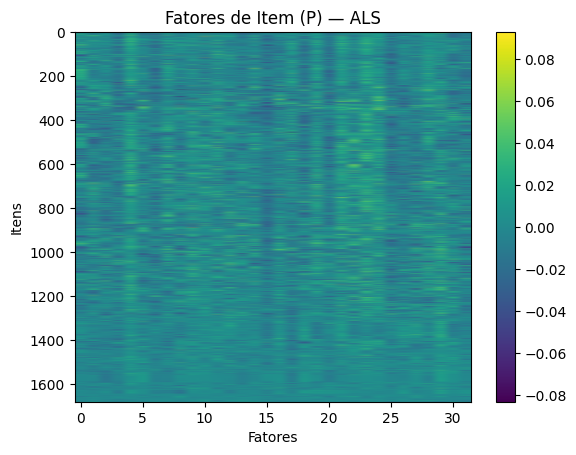

In [ ]:
plt.figure()
plt.imshow(X_als, aspect='auto')
plt.title('Fatores de Usuário (U) — ALS')
plt.xlabel('Fatores'); plt.ylabel('Usuários')
plt.colorbar(); plt.show()

plt.figure()
plt.imshow(Y_als, aspect='auto')
plt.title('Fatores de Item (P) — ALS')
plt.xlabel('Fatores'); plt.ylabel('Itens')
plt.colorbar(); plt.show()

## 6) Two-Tower (duas torres com embeddings)

In [ ]:
def make_pair_dataset(train_df, n_users, n_items, negatives_per_pos=3, seed=42):
    rng = np.random.default_rng(seed)
    by_user = train_df.groupby('uid')['iid'].apply(list).to_dict()
    rows = []
    for u, items in by_user.items():
        for i in items:
            rows.append((u,i,1))
            for _ in range(negatives_per_pos):
                j = rng.integers(0, n_items)
                while j in items:
                    j = rng.integers(0, n_items)
                rows.append((u,j,0))
    return pd.DataFrame(rows, columns=['uid','iid','label'])

pairs_df = make_pair_dataset(train_df, n_users, n_items, negatives_per_pos=3, seed=42)
pairs_tr, pairs_val = train_test_split(pairs_df, test_size=0.1, random_state=42, stratify=pairs_df['label'])
pairs_tr.shape, pairs_val.shape

((288000, 3), (32000, 3))

In [ ]:
embed_dim = 64
user_in = layers.Input(shape=(), dtype=tf.int32, name='user_id')
item_in = layers.Input(shape=(), dtype=tf.int32, name='item_id')

user_vec = layers.Embedding(n_users, embed_dim, name='user_emb')(user_in)
user_vec = layers.Flatten()(user_vec)
user_vec = layers.Dense(64, activation='relu', name='user_dense')(user_vec)

item_vec = layers.Embedding(n_items, embed_dim, name='item_emb')(item_in)
item_vec = layers.Flatten()(item_vec)
item_vec = layers.Dense(64, activation='relu', name='item_dense')(item_vec)

logits = layers.Dot(axes=1, name='dot')([user_vec, item_vec])
out = layers.Activation('sigmoid', name='sigmoid')(logits)

two_tower = Model([user_in, item_in], out, name='two_tower')
two_tower.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
two_tower.summary()

Model: "two_tower"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ user_id             │ (None)            │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ item_id             │ (None)            │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ user_emb            │ (None, 64)        │     60,352 │ user_id[0][0]     │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ item_emb            │ (None, 64)        │    107,648 │ item_id[0][0]     │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 64)        │          0 │ user_emb[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 64)        │          0 │ item_emb[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ user_dense (Dense)  │ (None, 64)        │      4,160 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ item_dense (Dense)  │ (None, 64)        │      4,160 │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dot (Dot)           │ (None, 1)         │          0 │ user_dense[0][0], │
│                     │                   │            │ item_dense[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sigmoid             │ (None, 1)         │          0 │ dot[0][0]         │
│ (Activation)        │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 176,320 (688.75 KB)

 Trainable params: 176,320 (688.75 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
batch_size = 2048
epochs = 5

ds_tr = tf.data.Dataset.from_tensor_slices((
    {'user_id': pairs_tr['uid'].values, 'item_id': pairs_tr['iid'].values},
    pairs_tr['label'].values.astype('float32')
)).shuffle(200_000).batch(batch_size).prefetch(tf.data.AUTOTUNE)

ds_val = tf.data.Dataset.from_tensor_slices((
    {'user_id': pairs_val['uid'].values, 'item_id': pairs_val['iid'].values},
    pairs_val['label'].values.astype('float32')
)).batch(batch_size).prefetch(tf.data.AUTOTUNE)

history = two_tower.fit(ds_tr, validation_data=ds_val, epochs=epochs, verbose=1)

Epoch 1/5
141/141 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.4622 - loss: 0.6934 - val_accuracy: 0.7382 - val_loss: 0.6771
Epoch 2/5
141/141 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.7860 - loss: 0.6748 - val_accuracy: 0.8001 - val_loss: 0.6744
Epoch 3/5
141/141 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.7890 - loss: 0.6697 - val_accuracy: 0.8068 - val_loss: 0.6677
Epoch 4/5
141/141 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.8046 - loss: 0.6646 - val_accuracy: 0.8003 - val_loss: 0.6665
Epoch 5/5
141/141 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.8006 - loss: 0.6632 - val_accuracy: 0.8158 - val_loss: 0.6655


### Avaliação do Two-Tower (Recall@K e NDCG@K)

In [ ]:
# === Avaliação do Two-Tower (versão robusta a nomes de InputLayer) ===

import numpy as np
from tensorflow.keras import Model

def _safe_get_layer(model, name_candidates):
    for n in name_candidates:
        try:
            return model.get_layer(n)
        except:
            continue
    return None

# 1) Pegue as ENTRADAS diretamente do modelo (evita InputLayer sem nome)
user_in_tensor = two_tower.inputs[0]   # entrada da torre de usuário
item_in_tensor = two_tower.inputs[1]   # entrada da torre de item

# 2) Pegue as SAÍDAS de cada torre (ajuste os nomes se tiver alterado no seu caderno)
user_dense = _safe_get_layer(two_tower, ["user_dense", "dense_user", "user_tower_dense"])
item_dense = _safe_get_layer(two_tower, ["item_dense", "dense_item", "item_tower_dense"])

assert user_dense is not None, "Camada de saída da torre de usuário não encontrada (ex.: 'user_dense')."
assert item_dense is not None, "Camada de saída da torre de item não encontrada (ex.: 'item_dense')."

# 3) Construa modelos “encoders” de cada torre
user_encoder = Model(inputs=user_in_tensor, outputs=user_dense.output, name="user_encoder")
item_encoder = Model(inputs=item_in_tensor, outputs=item_dense.output, name="item_encoder")

# 4) Extraia embeddings U e P para TODOS os usuários/itens
U = user_encoder.predict(np.arange(n_users), batch_size=4096, verbose=0)
P = item_encoder.predict(np.arange(n_items), batch_size=4096, verbose=0)
print("Shapes -> U:", U.shape, "| P:", P.shape)

# 5) Funções utilitárias já definidas no caderno (reaproveitamos):
# - recommend_ttw_for_user(u, U, P, train_p, topk)
# - ndcg_at_k / recall_at_k
def eval_two_tower(U, P, train_p, test_p, k=10):
    recs, ndcgs = [], []
    for u in range(test_p.shape[0]):
        gt = test_p[u].indices.tolist()
        if not gt:
            continue
        reco = recommend_ttw_for_user(u, U, P, train_p, topk=max(100, k))
        recs.append(recall_at_k(reco, gt, k))
        ndcgs.append(ndcg_at_k(reco, gt, k))
    return float(np.mean(recs) if recs else 0.0), float(np.mean(ndcgs) if ndcgs else 0.0)


Shapes -> U: (943, 64) | P: (1682, 64)


In [ ]:
# Métricas @K (cole aqui se ainda não tiver no caderno)
import math
def recall_at_k(recommended, ground_truth, k=10):
    hits = len(set(recommended[:k]) & set(ground_truth))
    return hits / min(k, len(ground_truth)) if ground_truth else 0.0

def ndcg_at_k(recommended, ground_truth, k=10):
    gt = set(ground_truth)
    dcg = 0.0
    for rank, iid in enumerate(recommended[:k], start=1):
        if iid in gt:
            dcg += 1.0 / math.log2(rank + 1)
    ideal = min(len(ground_truth), k)
    idcg = sum(1.0 / math.log2(r+1) for r in range(1, ideal+1))
    return dcg / idcg if idcg > 0 else 0.0

# GERADOR de recomendações para o Two-Tower
def recommend_ttw_for_user(u, U, P, train_p, topk=10):
    # U: matriz de embeddings de usuário (n_users x d)
    # P: matriz de embeddings de item    (n_items x d)
    scores = U[u] @ P.T
    # não recomende itens já vistos no treino
    seen = set(train_p[u].indices.tolist())
    ranking = np.argsort(-scores)          # ids de itens, do maior p/ menor score
    ranking = [i for i in ranking if i not in seen]
    return ranking[:topk]

# Avaliação do Two-Tower
def eval_two_tower(U, P, train_p, test_p, k=10):
    recs, ndcgs = [], []
    for u in range(test_p.shape[0]):
        gt = test_p[u].indices.tolist()
        if not gt:
            continue
        reco = recommend_ttw_for_user(u, U, P, train_p, topk=max(100, k))
        recs.append(recall_at_k(reco, gt, k))
        ndcgs.append(ndcg_at_k(reco, gt, k))
    return float(np.mean(recs) if recs else 0.0), float(np.mean(ndcgs) if ndcgs else 0.0)

recall10_ttw, ndcg10_ttw = eval_two_tower(U, P, train_p, test_p, k=10)
print(f"Two-Tower — Recall@10: {recall10_ttw:.4f} | NDCG@10: {ndcg10_ttw:.4f}")



Two-Tower — Recall@10: 0.3245 | NDCG@10: 0.3274


### Diagrama das duas torres (ilustração)

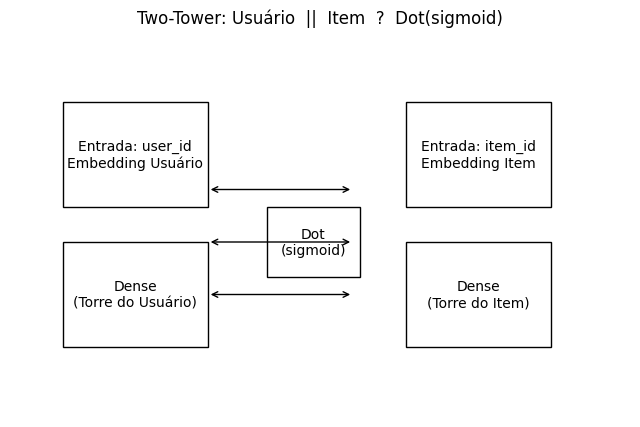

In [ ]:
fig, ax = plt.subplots(figsize=(8,5))

def box(ax, xy, w, h, text):
    rect = plt.Rectangle(xy, w, h, fill=False)
    ax.add_patch(rect)
    ax.text(xy[0]+w/2, xy[1]+h/2, text, ha='center', va='center')

box(ax, (0.4, 0.6), 1.1, 0.3, 'Entrada: user_id\nEmbedding Usuário')
box(ax, (0.4, 0.2), 1.1, 0.3, 'Dense\n(Torre do Usuário)')

box(ax, (3.0, 0.6), 1.1, 0.3, 'Entrada: item_id\nEmbedding Item')
box(ax, (3.0, 0.2), 1.1, 0.3, 'Dense\n(Torre do Item)')

box(ax, (1.95, 0.4), 0.7, 0.2, 'Dot\n(sigmoid)')

ax.annotate('', xy=(1.5,0.5), xytext=(2.6,0.5), arrowprops=dict(arrowstyle='<->'))
ax.annotate('', xy=(1.5,0.35), xytext=(2.6,0.35), arrowprops=dict(arrowstyle='<->'))
ax.annotate('', xy=(1.5,0.65), xytext=(2.6,0.65), arrowprops=dict(arrowstyle='<->'))

ax.set_xlim(0,4.7); ax.set_ylim(0,1.1); ax.axis('off')
plt.title('Two-Tower: Usuário  ||  Item  ?  Dot(sigmoid)')
plt.show()

## 7) Comparativo

In [ ]:
print(f'ALS       — Recall@10: {recall10_als:.4f} | NDCG@10: {ndcg10_als:.4f}')
print(f'Two-Tower — Recall@10: {recall10_ttw:.4f} | NDCG@10: {ndcg10_ttw:.4f}')

ALS       — Recall@10: 0.0647 | NDCG@10: 0.0521
Two-Tower — Recall@10: 0.3245 | NDCG@10: 0.3274
